In [74]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random
import os
from keras import utils

## Download dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

## Load dataset

In [ ]:
train_data = utils.image_dataset_from_directory(
    os.path.join(path, 'img_align_celeba', 'img_align_celeba'),
    labels=None,
    color_mode='rgb',
    image_size=(32, 32),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

In [46]:
def preprocess(img):
    img = tf.cast(img, 'float32') / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

## Build Sampling layer

In [47]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build Encoder Network

In [64]:
encoder_input = layers.Input(
    shape=(32, 32, 3), name='encoder_input'
)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(200, name='z_mean')(x)
z_log_var = layers.Dense(200, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

In [67]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_47 (Conv2D)             (None, 16, 16, 128)  3584        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 16, 16, 128)  512        ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_94 (LeakyReLU)     (None, 16, 16, 128)  0           ['batch_normalization_94[0]

## Build Decoder Network

In [66]:
decoder_input = layers.Input(
    shape=(200,), name='decoder_input'
)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2D(
    3,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

decoder = models.Model(decoder_input, decoder_output)

In [68]:
decoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_11 (Dense)            (None, 512)               102912    
                                                                 
 batch_normalization_98 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_98 (LeakyReLU)  (None, 512)               0         
                                                                 
 reshape_11 (Reshape)        (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose_43 (Conv2D  (None, 4, 4, 128)        147584    
 Transpose)                                               

## Define Variational AutoEncoder class

In [69]:
class VAE(models.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        recostruction = self.decoder(z)
        return z_mean, z_log_var, recostruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis = 1,
                )
            )

            total_loss = reconstruction_loss + kl_loss

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {m.name: m.result() for m in self.metrics}

# Train model

In [79]:
vae = VAE(encoder, decoder)

In [80]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [81]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(4
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [82]:
vae.fit(
    train,
    epochs=10,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=200),
    ],
)

Epoch 1/10


1583/1583 [==============================] - 3713s 2s/step - total_loss: 286.4581 - reconstruction_loss: 276.3665 - kl_loss: 10.0915
Epoch 2/10
1583/1583 [==============================] - 3719s 2s/step - total_loss: 284.5109 - reconstruction_loss: 273.6403 - kl_loss: 10.8706
Epoch 3/10
1583/1583 [==============================] - 3703s 2s/step - total_loss: 283.6908 - reconstruction_loss: 272.3300 - kl_loss: 11.3609
Epoch 4/10
1583/1583 [==============================] - 3650s 2s/step - total_loss: 283.1444 - reconstruction_loss: 271.4275 - kl_loss: 11.7168
Epoch 5/10
1583/1583 [==============================] - 3599s 2s/step - total_loss: 282.8859 - reconstruction_loss: 271.1152 - kl_loss: 11.7710
Epoch 6/10
1583/1583 [==============================] - 3759s 2s/step - total_loss: 282.7362 - reconstruction_loss: 270.9086 - kl_loss: 11.8275
Epoch 7/10
1583/1583 [==============================] - 3681s 2s/step - total_loss: 282.6238 - reconstruction_loss: 270.7672 - kl_loss: 11.8565
Epo

### Images and their reconstructions

In [ ]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)
example_images = example_images.reshape((-1, 32, 32, 3))

1/1 [==============================] - 0s 84ms/step


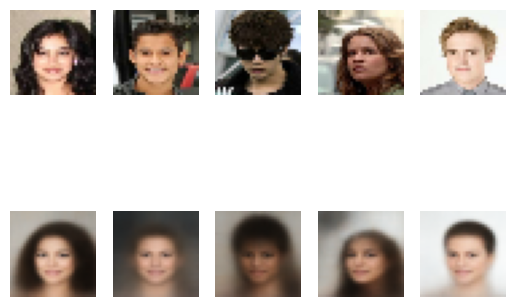

In [148]:
num_elems = 5

fig, axs = plt.subplots(2, num_elems)

for c in range(num_elems):
    img_idx = random.randint(0, example_images.shape[0] - 1)
    real_img = example_images[img_idx]
    reconstructed_img = vae.predict(real_img.reshape((1, 32, 32, 3)))[2].reshape((32, 32, 3))

    plt.sca(axs[0, c])

    plt.imshow(real_img)
    plt.axis('off')

    plt.sca(axs[1, c])

    plt.imshow(reconstructed_img)
    plt.axis('off')



## Generate new samples from normal distribution

1/1 [==============================] - 0s 58ms/step


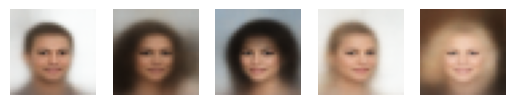

In [163]:
num_elems = 5

fig, axs = plt.subplots(1, num_elems)

for i in range(num_elems):
    code = np.random.normal(size=(200))
    gen_img = decoder.predict(code.reshape((1, -1)))
    gen_img = gen_img.reshape((32, 32, 3))
    plt.sca(axs[i])
    plt.imshow(gen_img, cmap='binary')
    plt.axis('off')

plt.show()

## Generate new samples from uniform distribution

1/1 [==============================] - 0s 68ms/step


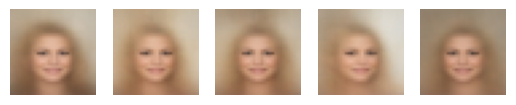

In [166]:
num_elems = 5

fig, axs = plt.subplots(1, num_elems)

for i in range(num_elems):
    code = np.random.uniform(size=(200))
    gen_img = decoder.predict(code.reshape((1, -1)))
    gen_img = gen_img.reshape((32, 32, 3))
    plt.sca(axs[i])
    plt.imshow(gen_img, cmap='binary')
    plt.axis('off')

plt.show()